# **Comparison of CO2 Emission Inventories for 2020 in the Amazon Region**

This code compares CO2 emissions from different emission inventories for the Amazon region in 2020. It processes data from FEER, GFED, and GFAS, then computes and visualizes the spatial and temporal patterns of emissions. The main steps are as follows:

1. **Data Loading**: The code loads the emission data for 2020 from FEER, GFED, and GFAS stored in NetCDF format. It also handles the geographic subset selection for the Amazon region using latitude and longitude bounds.
   
2. **Area Calculation**: It calculates the area of the selected region (Amazon) and the area of individual grid cells. The area calculation accounts for the Earth's curvature and uses the Haversine formula to estimate distances, which is essential for spatial integration of emissions.

3. **Emission Calculation**: The script extracts emission variables (e.g., CO2, CO, CH4) from the datasets and calculates the total emissions over time by summing or averaging the values across the latitude and longitude dimensions. This gives the spatial sum or mean for each time period.

4. **Temporal Integration**: The code integrates the emissions over time, converting the spatial emissions into total emissions in teragrams (Tg) of CO2 for easier comparison.

5. **Plotting and Comparison**: It generates a series of plots to compare the emissions from FEER, GFED, and GFAS over time. The user's own emissions data (calculated from their work) is also included in the comparison. The final plot is saved as a PNG file for further review.

The script provides a clear visual comparison of CO2 emissions from different inventories and allows for the assessment of biomass burning emissions in the Amazon during 2020.


In [ ]:
# Import necessary libraries for data processing, visualization, and geospatial analysis
from io import BytesIO  # Handle byte-stream data in memory
import glob  # Retrieve file paths using pattern matching
import s3fs  # Interact with Amazon S3 storage
import xarray as xr  # Handle multi-dimensional labeled data (e.g., NetCDF files)
import matplotlib.pyplot as plt  # Create static, animated, and interactive plots
import matplotlib.colors as colors  # Manage color mapping and normalization in plots
import cartopy.crs as ccrs  # Handle cartographic projections for geospatial data
import numpy as np  # Perform numerical computations
import cartopy  # Visualize geospatial data using maps
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # Format longitude/latitude labels in plots
from pyproj import Proj  # Perform coordinate reference system (CRS) transformations
import matplotlib.patches as mpatches  # Create custom legend elements for plots
import geopandas as gpd  # Handle and analyze geospatial vector data (e.g., shapefiles)
import os  # Perform file system operations
import pandas as pd  # Work with tabular data efficiently
import math  # Perform mathematical operations

In [ ]:
# Define the base directory containing the FEER inventory NetCDF files
base_folder_path = ".../FEERv1.0-G1.2/DAILY/"

# Define substrings to filter relevant NetCDF files based on emission type
search_terms = ["Daily_CO2", "Daily_CO", "Daily_CH4", "Daily_TPM"]  # Add or modify terms as needed

# Recursively search for NetCDF (.nc) files matching the defined search terms
nc_files = []
for root, dirs, files in os.walk(base_folder_path):
    for file in files:
        if file.endswith(".nc") and any(term in file for term in search_terms):
            nc_files.append(os.path.join(root, file))  # Store the full file paths

# Display the list of matching NetCDF files
print("Matching NetCDF files:")

# Define the time range for data selection
start_date = "2020-05-30"
end_date = "2020-12-15"

# Open and merge multiple NetCDF files using xarray, combining them along the coordinate dimensions
ds_FEER = xr.open_mfdataset(nc_files, combine="by_coords")

# Filter the dataset to retain only data within the specified time range
ds_filtered_FEER = ds_FEER.sel(time=slice(start_date, end_date))

# Define the geographical bounding box for the region of interest (Amazon region)
minlon, maxlon, minlat, maxlat = -72, -48, -11, -3

# Extract a spatial subset of the dataset based on the defined latitude and longitude boundaries
ds_subset_FEER = ds_filtered_FEER.sel(
    lat=slice(maxlat, minlat),  # latitudes should be in descending order for slicing
    lon=slice(minlon, maxlon)   # longitudes in ascending order
)

In [ ]:
# Define the base directory containing the GFED inventory NetCDF files
folder_path = "../GFED_data/"

# Define substrings to filter relevant NetCDF files (e.g., files from 2020)
search_terms = ["2020"]

# Retrieve all NetCDF (.nc) files in the directory that match the search terms
nc_files_GFED = [
    os.path.join(folder_path, file)
    for file in os.listdir(folder_path)
    if file.endswith(".nc") and any(term in file for term in search_terms)
]

# Define the time range for data selection
start_date = "2020-05-30"
end_date = "2020-12-15"

# Open and merge multiple NetCDF files using xarray, combining them along the coordinate dimensions
ds_GFED = xr.open_mfdataset(nc_files_GFED, combine="by_coords")

# Filter the dataset to retain only data within the specified time range
ds_filtered_GFED = ds_GFED.sel(time=slice(start_date, end_date))

# Define the geographical bounding box for the region of interest (Amazon region)
minlon, maxlon, minlat, maxlat = -72, -48, -11, -3

# Extract a spatial subset of the dataset based on the defined latitude and longitude boundaries
ds_subset_GFED = ds_filtered_GFED.sel(
    lat=slice(maxlat, minlat),  # latitudes should be in descending order for slicing
    lon=slice(minlon, maxlon)   # longitudes in ascending order
)

In [ ]:
# Open the NetCDF file for the GFAS inventory. 
# The GFAS dataset is provided as a single NetCDF file, where the time range can be selected from the data source.
ds_GFAS = xr.open_dataset('./GFAS_2020.nc')

# The GFAS dataset uses a longitude range of 0 to 360 instead of -180 to 180.
# To match the desired region (Amazon region), the longitudes need to be adjusted accordingly.
minlon, maxlon, minlat, maxlat = 288, 312, -11, -3  # Corresponding to -72° to -48° in a -180 to 180 system

# Extract a spatial subset of the dataset based on the defined latitude and longitude boundaries
ds_subset_GFAS = ds_GFAS.sel(
    latitude=slice(maxlat, minlat),  # Latitudes should be in descending order for slicing
    longitude=slice(minlon, maxlon)  # Longitudes in ascending order
)

In [ ]:
# Define Earth's radius in kilometers
R = 6371  # Approximate radius of Earth in km

# Define the geographical bounding box (Amazon region in GFAS dataset)
minlat, maxlat = -11, -3
minlon, maxlon = 288, 312  # GFAS longitudes range from 0 to 360

# Convert longitudes from [0, 360] to [-180, 180] for proper distance calculations
if minlon > 180:
    minlon -= 360
if maxlon > 180:
    maxlon -= 360

# Function to compute the great-circle distance between two points using the Haversine formula
def haversine_distance(lat1, lat2, lon1, lon2):
    """
    Calculate the great-circle distance (in km) between two points on Earth 
    given their latitudes and longitudes.
    """
    dlat = np.radians(lat2 - lat1)  # Convert latitude difference to radians
    dlon = np.radians(lon2 - lon1)  # Convert longitude difference to radians
    a = (np.sin(dlat / 2) ** 2 + 
         np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c  # Return distance in kilometers

# Compute the north-south distance (height of the box) using latitude values
height_km = haversine_distance(minlat, maxlat, minlon, minlon)

# Compute the east-west distance (width of the box) using longitude values
width_km = haversine_distance(minlat, minlat, minlon, maxlon)

# Compute the approximate area in square kilometers and convert to square meters
area_km2 = height_km * width_km
area_m2 = area_km2 * 1e6  # Convert km² to m²

# Print the computed area
print(f"The area of the box is approximately {area_km2:.2f} km²")
print(f"The area of the box is approximately {area_m2:.2f} m²")

In [ ]:
def calculate_cell_area(latitude, resolution=0.1):
    """
    Calculate the approximate area of a grid cell at a given latitude, considering Earth's curvature.
    
    Parameters:
    - latitude (float): Latitude in degrees (negative for Southern Hemisphere).
    - resolution (float): Spatial resolution in degrees (default is 0.1°).
    
    Returns:
    - float: Estimated area of the grid cell in square meters.
    """
    # Earth's radius in meters
    R = 6371000  

    # Convert resolution from degrees to radians
    resolution_rad = math.radians(resolution)
    
    # Compute the north-south length of the cell (constant for all latitudes)
    lat_length = resolution_rad * R
    
    # Compute the east-west length of the cell (varies with latitude due to Earth's curvature)
    lon_length = resolution_rad * R * math.cos(math.radians(latitude))
    
    # Compute the total area of the grid cell
    cell_area = lat_length * lon_length
    return cell_area

# Example usage: Calculate the area of a 0.1° × 0.1° grid cell at different latitudes
latitude = 0  # Equator
area_at_equator = calculate_cell_area(latitude)
print(f"Area of 0.1°x0.1° cell at latitude {latitude}°: {area_at_equator:.2f} m²")

latitude = 45  # Mid-latitude
area_at_mid_latitude = calculate_cell_area(latitude)
print(f"Area of 0.1°x0.1° cell at latitude {latitude}°: {area_at_mid_latitude:.2f} m²")

In [ ]:
# Compute the sum over spatial coverage (latitude and longitude) for each time period
variable_FEER = "CO2"  # Replace with the desired variable
variable_GFED = "CO2"  # Replace with the desired variable
variable_GFAS = "co2fire"  # Replace with the desired variable

# Compute the spatial sum (or mean where appropriate) for each dataset
flux_FEER = ds_subset_FEER[variable_FEER].sum(dim=["lat", "lon"])
flux_GFED = ds_subset_GFED[variable_GFED].mean(dim=["lat", "lon"])
flux_GFAS = ds_subset_GFAS[variable_GFAS].mean(dim=["latitude", "longitude"])

# Extract time variables for each dataset
time_gfed = ds_subset_GFED.time
time_gfas = ds_subset_GFAS.valid_time  # Ensure this exists in ds_subset_GFAS

# Convert flux values to appropriate units
values_GFED = (flux_GFED * area_m2) / 1e3  # Convert to kg
values_GFAS = flux_GFAS * area_m2 * (3600 * 24)  # Convert to daily emissions in kg
values_FEER = flux_FEER * area_at_equator * (3600 * 24)  # Convert to daily emissions in kg

# Plot the spatially aggregated data over time
plt.figure(figsize=(12, 6))
plt.plot(time_gfed, values_FEER, marker='o', linestyle='-', label=f'Spatial average of {variable_FEER} (FEER)')
plt.plot(time_gfed, values_GFED, marker='o', linestyle='-', label=f'Spatial average of {variable_GFED} (GFED)')
plt.plot(time_gfas, values_GFAS, marker='o', linestyle='-', label=f'Spatial average of {variable_GFAS} (GFAS)')

# Set plot labels and formatting
plt.title(f'Spatial Average of {variable_GFED} Over Time')
plt.xlabel('Time')
plt.ylabel(f'{variable_GFED} (kg)')
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Define the directory where emission data files are stored
datadir = '../Emission_processed_data'

# Define the year for processing
Year = 2020  
# Example of expected file format: "goes_data_emission_rate_amazon_definitive_box_2020_150_350.csv"

# Retrieve all matching files for the specified year
data = sorted(glob.glob(datadir + f'/*goes_data_emission_rate_amazon_definitive_box_{Year}_150_350.csv'))
# print(data)  # Uncomment for debugging to see the list of files found

# List of all available columns in the dataset:
# sat, year, julian, hhmm, code, central_lat, central_lon, FRP(MW), N_FRP, FRE(MJ), RE(kg/s), ME(kg),
# CO_2(kg), sigma_CO_2(kg), CO(kg), sigma_CO(kg), CH4(kg), sigma_CH4(kg), mean_FRP, mean_temp

# Select only the relevant columns for analysis
selected_columns = [
    'central_lat', 'central_lon', 'julian', 'ME(kg)', 'CO_2(kg)', 'sigma_CO_2(kg)',
    'CO(kg)', 'sigma_CO(kg)', 'CH4(kg)', 'sigma_CH4(kg)'
]

# Read the first CSV file, extracting only the selected columns
emission_data = pd.read_csv(data[0], usecols=selected_columns)

# Extract column names from the loaded dataset
header = list(emission_data)

# Extract Julian day column and convert to a NumPy array, removing NaN values
pos1 = header.index('julian')
column1 = emission_data.iloc[:, pos1]
julian = np.array(column1.dropna(), dtype=pd.Series)

# Extract CO2 emission values (kg) and convert to a NumPy array, removing NaN values
pos3 = header.index('CO_2(kg)')
column3 = emission_data.iloc[:, pos3]
TPM = np.array(column3.dropna(), dtype=pd.Series)

# The TPM emission data is reported every 10 minutes.
# To obtain daily total emissions, we sum the values for each unique Julian day.
days = np.unique(julian)
matriz = []

for i in range(np.min(days), np.max(days) + 1):
    # Find all indices where the Julian day matches the current day
    index = np.where(julian == i)
    
    # Sum the emissions for the day
    daily_sum = np.sum(TPM[index])
    
    # Append the daily total emissions to the matrix
    matriz = np.append(matriz, daily_sum)

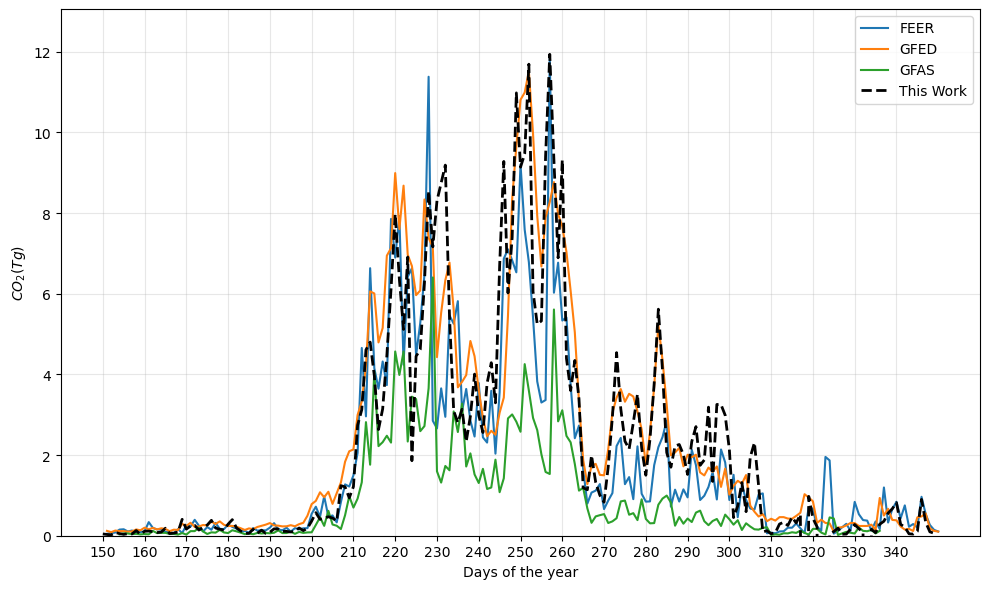

In [96]:
# Extract Day of Year (DOY) from time variables for each dataset
DOY = ds_subset_GFED['time'].dt.dayofyear  # GFED dataset
DOY_GFAS = time_gfas.dt.dayofyear  # GFAS dataset

# Define x-axis tick marks at 10-day intervals
day_ticks = np.arange(np.min(days), np.max(days) + 1, 10)

# Create the figure for plotting
plt.figure(figsize=(10, 6))

# Set y-axis limits, allowing a 10% margin above the maximum FEER value (converted to Tg)
plt.ylim(0, np.max(values_FEER) * 1.1 / 1e9)

# Plot daily emissions for each dataset, converting kg to teragrams (Tg)
plt.plot(DOY, values_FEER / 1e9, marker='', linestyle='-', label='FEER')  # FEER emissions
plt.plot(DOY, values_GFED / 1e9, marker='', linestyle='-', label='GFED')  # GFED emissions
plt.plot(DOY_GFAS, values_GFAS / 1e9, marker='', linestyle='-', label='GFAS')  # GFAS emissions

# Plot emissions from this work, using a dashed black line
plt.plot(days, matriz / 1e9, color='black', linewidth=2, marker='', linestyle='--', label='This Work')

# Set x-axis labels and formatting
plt.xticks(day_ticks)  # Use 10-day intervals for better readability
plt.xlabel('Days of the year')  # X-axis label
plt.ylabel(r'$CO_2 (Tg)$')  # Y-axis label in teragrams

# Customize grid appearance (light transparency)
plt.grid(True, alpha=0.3)

# Add legend to distinguish datasets
plt.legend()

# Optimize layout to prevent overlapping labels
plt.tight_layout()

# Save the figure as a high-resolution PNG file
plt.savefig('compare_emission_inventories_2020.png', dpi=300)

# Uncomment the next line if you want to display the plot
# plt.show()